# VERSIONFinal

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")

parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

# Add comment
from nilearn.image import concat_imgs
import os.path as op

In [2]:
################
# Start FSLeyes 
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

Gtk-Message: 17:08:51.838: Failed to load module "canberra-gtk-module"

(ipykernel_launcher.py:11874): Gtk-CRITICAL **: 17:08:51.955: gtk_window_resize: assertion 'height > 0' failed


# Load openneuro files

In [3]:
#"https://openneuro.org/datasets/ds000171/versions/00001"
dataset_id= 'ds000171'
subject = 'control01'

#path to save
sample_path = "/home/jovyan/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", op.join(subject_dir, '*'),# We are asking to get all files within the subject_dir folder by using the wildcard *
               ], check=True)
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'fmap'))



👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 436 entities [00:30, 14.20 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   1%|          | 83.6k/8.77M [00:00<00:19, 477kB/s]
sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]
sub-control01_T1w.nii.gz:   3%|▎         | 238k/8.77M [00:00<00:09, 961kB/s]        
sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 0.00/33.8M [00:00<?, ?B/s]


sub-control01_T1w.nii.gz:   6%|▌         | 543k/8.77M [00:00<00:04, 1.80MB/s]0<?, ?B/s]
sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 83.6k/33.9M [00:00<01:13, 480kB/s]

sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 83.6k/33.8M [00:00<01:14, 476kB/s]


sub-control01_T1w.nii.gz:  14%|█▍        | 1.23M/8.77M [00:00<00:02, 3.06MB/s]0<01:13, 485kB/s]



sub-control01_task-music_run-3_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]



                                                                                    
sub-control01_task

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 


In [4]:
print_dir_tree(bids_root,5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [5]:
func_path = op.join(bids_root, 'sub-control01', 'func')
anat_path = op.join(bids_root, 'sub-control01', 'anat','sub-control01_T1w.nii.gz')

# Concatenate all runs

In [6]:
# Load the event data from each run
events1 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
events2 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
events3 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

#Adjust onset time for run 2 and 3
run1_duration = events1['onset'].max() + events1['duration'].iloc[-1]
run2_duration = events2['onset'].max() + events2['duration'].iloc[-1]

events2['onset'] += run1_duration
events3['onset'] += (run1_duration + run2_duration)

# Concatenate the table
combined_events = pd.concat([events1, events2, events3], ignore_index=True)

# Save the combined result to a new file or display it
combined_events.to_csv(op.join(func_path, 'combined_events.tsv'), sep='\t', index=False)
combined_events

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [7]:
# concatenation of FMRI preprocessed data
preprocessed_files = [
    op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz'),
    op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold.nii.gz'),
    op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_bold.nii.gz')
]

# Concatenate the 4D fMRI images
fmri_img = concat_imgs(preprocessed_files)
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat.nii.gz')
fmri_img.to_filename(output_path)

In [8]:
print_dir_tree(bids_root,5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ fmap/
|------------ func/
|--------------- sub-control01_task-music_concat.nii.gz
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- combined_events.tsv
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


# Preprocessing

## Anatomical (skull stripping + segmentation)

In [9]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    brain_no_skull_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_no_skull'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, brain_no_skull_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "control01")

Done with BET.


## DEMANDER DAPH

In [10]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))

apply_fsl_math_approach(anat_path, resulting_mask_path, op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_no_skull.nii.gz'))

Image Exception : #63 :: No image files match: /home/jovyan/data/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask
Image Exception : #22 :: Failed to read volume /home/jovyan/data/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask
Error : No image files match: /home/jovyan/data/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask
terminate called after throwing an instance of 'std::runtime_error'
  what():  Failed to read volume /home/jovyan/data/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask
Error : No image files match: /home/jovyan/data/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask
/cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.7.4_20231005/fslmaths: line 3: 12108 Aborted                 (core dumped) singularity --silent exec $neurodesk_singularity_opts --pwd "$PWD" /cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.7.4_20231005

In [11]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_no_skull_mask.nii.gz'))


(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:09:47.757: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:09:47: Debug: ClientToScreen cannot work when toplevel window is not shown
17:09:47: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:09:47.759: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:09:47: Debug: ClientToScreen cannot work when toplevel window is not shown
17:09:47: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:09:47.760: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:09:47: Debug: ClientToScreen cannot work when toplevel window is not shown
17:09:47: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:09:47.761: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:09:47: Debug: ClientToScreen cannot work when topleve

In [12]:
[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))] 
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_no_skull_fast')
fast(imgs=[op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_no_skull.nii.gz')], out=segmentation_path, n_classes=3)

{}

In [13]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w_no_skull.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_seg.nii.gz
|--------------- sub-control01_T1w_no_skull_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_task-music_concat.nii.gz
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- combined_events.tsv
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-contro

## 1.3 Anatomical Normalization (Demander à Daph)

In [14]:
from fsl.wrappers import flirt

subject_id = 'control01'
subject_anatomical = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-control01_T1w_no_skull')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical
reference = mni_template

#FLIRT Linear
result = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt(target, reference, out=result)

#FNIRT non-linear
moving_image = ants.image_read(target + '.nii.gz')
fixed_image = ants.image_read(reference + '.nii.gz')

transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = 'SyN' )
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
resultAnts = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subject_id))
ants.image_write(warpedImage, resultAnts)


Final result: 
0.006220 0.002853 -1.112216 204.408173 
-0.943018 0.533958 0.001633 177.630188 
0.538434 1.083527 -0.014732 -158.840588 
0.000000 0.000000 0.000000 1.000000 



In [15]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference)
fsleyesDisplay.load(result)
fsleyesDisplay.load(resultAnts)


(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:14:57.378: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:14:57: Debug: ClientToScreen cannot work when toplevel window is not shown
17:14:57: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:14:57.380: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:14:57: Debug: ClientToScreen cannot work when toplevel window is not shown
17:14:57: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:14:57.382: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:14:57: Debug: ClientToScreen cannot work when toplevel window is not shown
17:14:57: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:14:57.384: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:14:57: Debug: ClientToScreen cannot work when topleve

## Functional (Motion Correction + smoothing)

In [16]:
from fsl.wrappers import mcflirt

In [17]:
concat_path = output_path

In [18]:
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_bold_moco')
mcflirt(infile=concat_path,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292]

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [19]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|--------------- sub-control01_T1w_no_skull.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_no_skull_fast_seg.nii.gz
|--------------- sub-control01_T1w_no_skull_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_task-music_bold_moco.nii.gz
|--------------- sub-control01_task-music_bold_moco.par
|--------------- sub-control01_task-music_concat.nii.gz
|--------------- sub-control01_t

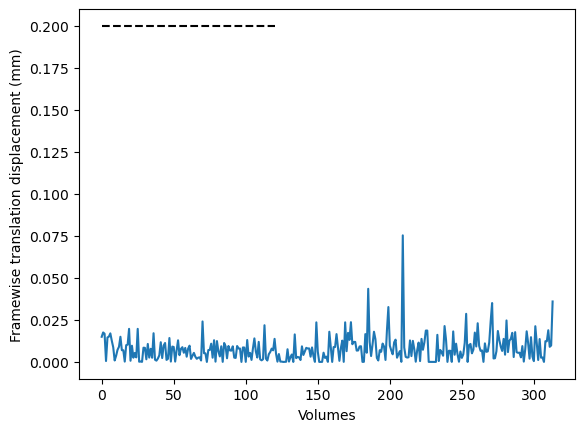

In [20]:
import matplotlib.pyplot as plt
import nibabel as nib
#inspect the translation on X 
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_bold_moco.par'))

trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 120,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

# There are basically (if looking only along X translation) no frame displacement above 0.2mm!

In [21]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [22]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

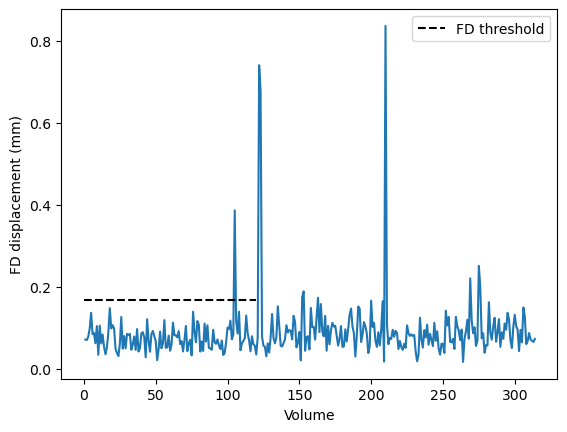

In [23]:
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 120,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()
#no volumes above threshold

## Coregistration of functional to anatomical

In [24]:
subprocess.run(['epi_reg'])


Usage: epi_reg [options] --epi=<EPI image> --t1=<wholehead T1 image> --t1brain=<brain extracted T1 image> --out=<output name>
 
Optional arguments
  --fmap=<image>         : fieldmap image (in rad/s)
  --fmapmag=<image>      : fieldmap magnitude image - wholehead extracted
  --fmapmagbrain=<image> : fieldmap magnitude image - brain extracted
  --gdc=<image>          : Gradient-distortion corection warpfield
  --wmseg=<image>        : white matter segmentation of T1 image
  --echospacing=<val>    : Effective EPI echo spacing (sometimes called dwell time) - in seconds
  --pedir=<dir>          : phase encoding direction, dir = x/y/z/-x/-y/-z
  --weight=<image>       : weighting image (in T1 space)
  --nofmapreg            : do not perform registration of fmap to T1 (use if fmap already registered) 
  --noclean              : do not clean up intermediate files
  -v                     : verbose output
  -h                     : display this help message
 
e.g.:  epi_reg --epi=example_func

CompletedProcess(args=['epi_reg'], returncode=1)

In [38]:
from fsl.wrappers import epi_reg

output_path_final = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-sitrep_bold_bbr')
ref_vol_name =  op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-sitrep_bold_moco_vol_middle')
brain_no_skull_path = op.join(preproc_root, 'sub-control01', 'anat','sub-control01_T1w_no_skull.nii.gz')

use_single_vol = True

if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    fslroi(path_moco_data, ref_vol_name, str(157), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(anat_path), '--t1brain={}'.format(brain_no_skull_path), '--out={}'.format(output_path_final)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(path_moco_data), '--t1={}'.format(anat_path ), '--t1brain={}'.format(brain_no_skull_path), '--out={}'.format(output_path_final)])


Running FAST segmentation


KeyboardInterrupt: 


(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:34:55.656: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [26]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(brain_no_skull_path)
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-sitrep_bold_bbr_fast_wmedge'))


(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:20:21.928: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:20:21: Debug: ClientToScreen cannot work when toplevel window is not shown
17:20:21: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:20:21.930: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:20:21: Debug: ClientToScreen cannot work when toplevel window is not shown
17:20:21: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:20:21.931: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:20:21: Debug: ClientToScreen cannot work when toplevel window is not shown
17:20:21: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:20:21.933: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:20:21: Debug: ClientToScreen cannot work when topleve

In [27]:
a = nib.load(output_path_final)
b = a.shape
b

(80, 80, 50, 315)

In [28]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

cleanup_epi_reg(op.join(preproc_root, 'sub-control01', 'func'))

In [29]:
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat.nii.gz', '-s', '2.547987090198743', '/home/jovyan/data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat.nii.gz_smoothed-6mm'], returncode=0)

In [30]:
 fsleyesDisplay.resetOverlays()
 fsleyesDisplay.load(output_path + '_smoothed-6mm')


(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:21:02.452: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:21:02: Debug: ClientToScreen cannot work when toplevel window is not shown
17:21:02: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:21:02.453: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:21:02: Debug: ClientToScreen cannot work when toplevel window is not shown
17:21:02: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:21:02.454: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:21:02: Debug: ClientToScreen cannot work when toplevel window is not shown
17:21:02: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:11874): Gdk-WARNING **: 17:21:02.456: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:21:02: Debug: ClientToScreen cannot work when topleve

In [31]:
fmri_img = nib.load(output_path)
fmri_img_shape = fmri_img.shape
fmri_img_shape

(80, 80, 50, 315)

In [32]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img,combined_events)

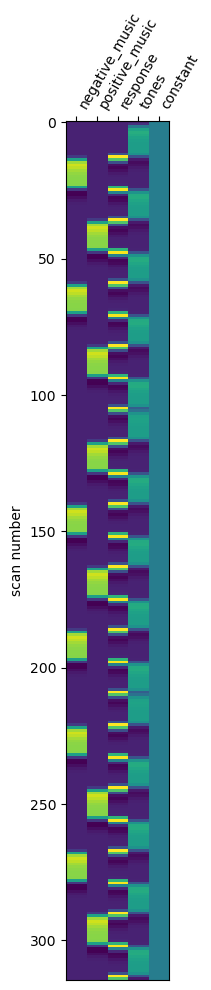

In [33]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [34]:
# Create the dictionary of the conditions

conditions = {
    'negative_music': np.array([1,0,0,0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'positive_music':np.array([0,1,0,0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
    'response':np.array([0,0,1,0,0]),
    'tones':np.array([0,0,0,1,0])
}
posi_min_nega = conditions['positive_music'] - conditions['negative_music']

<Axes: label='conditions'>

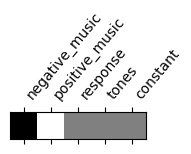

In [35]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(posi_min_nega, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE

In [36]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(posi_min_nega,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

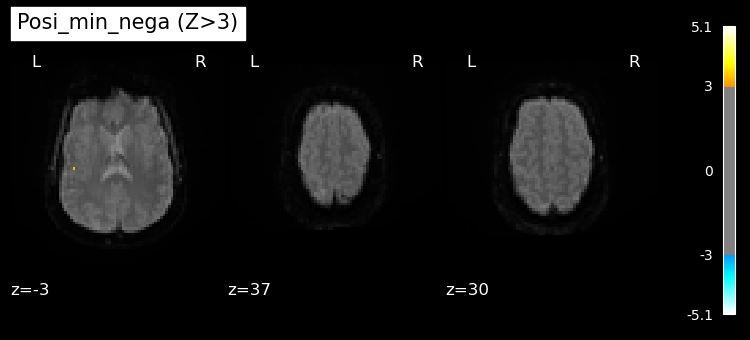

In [37]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-3,37,30], black_bg=True,
              title='Posi_min_nega (Z>3)')
plt.show()